腦部腫瘤分類（Pytorch）mobilenet_v3_large版本

準備動作（導入模組）

In [92]:
!pip install torchsummary
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.metrics import accuracy_score,classification_report

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import time
import warnings
from collections import OrderedDict
warnings.simplefilter("ignore")

You should consider upgrading via the 'C:\Users\marti\anaconda3\python.exe -m pip install --upgrade pip' command.


下載模型/預設GPU

In [93]:
# download the pretrained model
import torchvision.models as models
model = models.mobilenet_v3_large(pretrained = True)

In [94]:
trainig_path = 'data/Training'
testing_path = 'data/Testing'

IMAGE_SIZE=(128,128)
batch_size=64
learning_rate = 0.0008
epochs=50
num_classes=4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義數據集處理的方法

In [95]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
#             transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

    return data_transformation

從訓練集中讀取醫療影像數據

In [96]:
trainset=datasets.ImageFolder(trainig_path,transform=images_transforms('training'))
testset=datasets.ImageFolder(testing_path,transform=images_transforms('test'))
testset, valset = torch.utils.data.random_split(testset, [150, 244])

取得各病徵編號

In [97]:
print(trainset.class_to_idx)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


加載醫療影像，一個批次64筆資料，且打亂順序

In [98]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

輸出樣本，隨機列出訓練集中的醫療影像

In [99]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


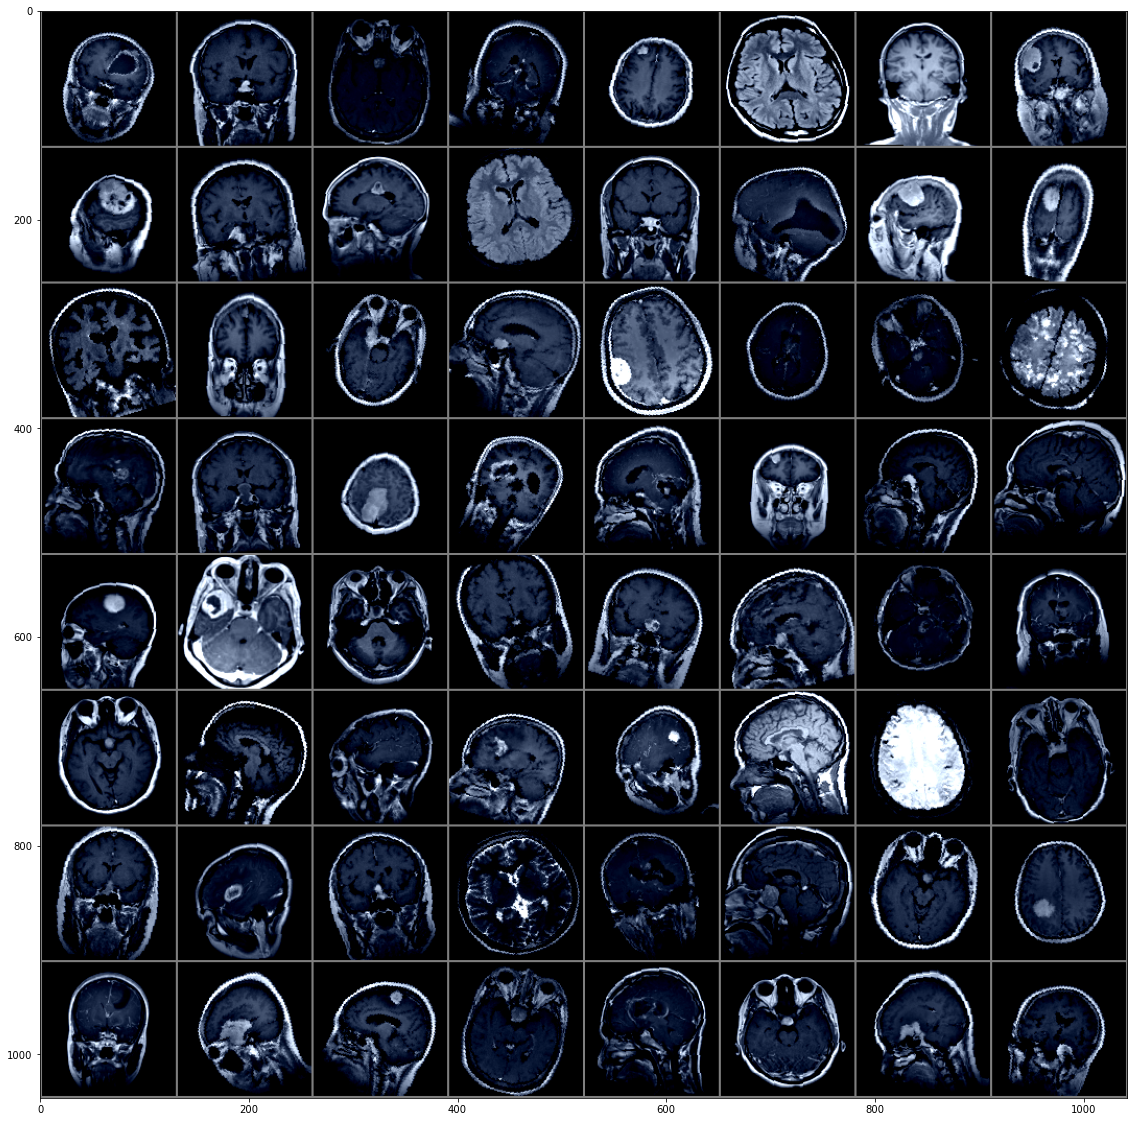

In [100]:
examples = iter(train_loader)
images,labels = examples.next()
imshow(torchvision.utils.make_grid(images))

預設只訓練分類器

In [101]:
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False

建構神經網路的模型

In [102]:
#Classifier architecture to put on top of mobilenet_v3_large
input = model.classifier[0].in_features
model.classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input,1024)),
    ('relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(1024,2048)),
    ('relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(2048,num_classes)),
]))

In [103]:
#shifting model to gpu
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)

模型可視化

In [104]:
IMAGE_SIZE=(3,)+IMAGE_SIZE
print(summary(model,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           1,024
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]             576
      BatchNorm2d-14           [-1, 64,

訓練模型，并印出損失函數

In [105]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        model.eval()
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)

            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            predictes=torch.max(outputs,1)[1]
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()

        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        return y_actual,y_pred

def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    # np.inf 表示+∞，是没有確切的數值的,類型為浮點數
    min_loss = np.Inf

    since = time.time()
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()

            predictes = torch.max(outputs,1)[1]
            y_actual += list(labels.data.cpu().numpy().flatten())
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            predictes=torch.max(outputs,1)[1]
            y_actual += list(labels.data.cpu().numpy().flatten())
            y_pred += list(predictes.detach().cpu().numpy().flatten())

        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'model\\mobilenet_v3_large.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [106]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,epochs)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 1/50 Train loss: 0.835277,Validation loss: 1.426344, Train AUC: 0.6488  Validation AUC: 0.6339
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 2/50 Train loss: 0.584349,Validation loss: 1.448831, Train AUC: 0.7704  Validation AUC: 0.7473
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 3/50 Train loss: 0.458972,Validation loss: 1.435771, Train AUC: 0.8185  Validation AUC: 0.7961
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 4/50 Train loss: 0.414165,Validation loss: 1.704322, Train AUC: 0.8411  Validation AUC: 0.8128
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 5/50 Train loss: 0.365220,Validation loss: 2.037860, Train AUC: 0.8547  Validation AUC: 0.8266
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 6/50 Train loss: 0.337702,Validation loss: 1.905859, Train AUC: 0.8613  Validation AUC: 0.8337
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 7/50 Train loss: 0.324743,Validation loss: 1.739700, Train AUC: 0.8798  Validation AUC: 0.8510
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 8/50 Train loss: 0.287481,Validation loss: 2.224016, Train AUC: 0.8913  Validation AUC: 0.8606
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 9/50 Train loss: 0.283964,Validation loss: 1.568913, Train AUC: 0.8895  Validation AUC: 0.8626
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 10/50 Train loss: 0.264480,Validation loss: 2.257076, Train AUC: 0.9035  Validation AUC: 0.8725
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 11/50 Train loss: 0.227777,Validation loss: 1.785366, Train AUC: 0.9157  Validation AUC: 0.8860
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 12/50 Train loss: 0.238687,Validation loss: 1.880675, Train AUC: 0.9091  Validation AUC: 0.8809
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 13/50 Train loss: 0.218427,Validation loss: 2.019452, Train AUC: 0.9174  Validation AUC: 0.8899
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 14/50 Train loss: 0.214476,Validation loss: 2.023278, Train AUC: 0.9220  Validation AUC: 0.8924
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 15/50 Train loss: 0.186634,Validation loss: 1.605633, Train AUC: 0.9258  Validation AUC: 0.9033
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 16/50 Train loss: 0.182585,Validation loss: 1.574313, Train AUC: 0.9286  Validation AUC: 0.9062
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 17/50 Train loss: 0.164639,Validation loss: 1.695381, Train AUC: 0.9401  Validation AUC: 0.9188
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 18/50 Train loss: 0.172367,Validation loss: 1.762671, Train AUC: 0.9341  Validation AUC: 0.9152
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 19/50 Train loss: 0.163740,Validation loss: 2.133168, Train AUC: 0.9401  Validation AUC: 0.9184
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 20/50 Train loss: 0.168362,Validation loss: 1.710774, Train AUC: 0.9373  Validation AUC: 0.9191
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 21/50 Train loss: 0.142410,Validation loss: 1.815024, Train AUC: 0.9484  Validation AUC: 0.9290
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 22/50 Train loss: 0.137445,Validation loss: 1.889642, Train AUC: 0.9498  Validation AUC: 0.9316
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 23/50 Train loss: 0.121756,Validation loss: 2.116914, Train AUC: 0.9516  Validation AUC: 0.9303
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 24/50 Train loss: 0.144523,Validation loss: 1.986632, Train AUC: 0.9415  Validation AUC: 0.9236
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 25/50 Train loss: 0.108784,Validation loss: 2.044127, Train AUC: 0.9631  Validation AUC: 0.9435
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 26/50 Train loss: 0.101828,Validation loss: 2.521858, Train AUC: 0.9627  Validation AUC: 0.9422
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 27/50 Train loss: 0.118785,Validation loss: 2.347861, Train AUC: 0.9533  Validation AUC: 0.9335
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 28/50 Train loss: 0.106117,Validation loss: 2.530881, Train AUC: 0.9589  Validation AUC: 0.9364
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 29/50 Train loss: 0.119701,Validation loss: 2.380381, Train AUC: 0.9561  Validation AUC: 0.9351
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 30/50 Train loss: 0.088271,Validation loss: 2.031791, Train AUC: 0.9711  Validation AUC: 0.9509
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 31/50 Train loss: 0.090652,Validation loss: 2.129110, Train AUC: 0.9652  Validation AUC: 0.9444
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 32/50 Train loss: 0.092188,Validation loss: 2.426203, Train AUC: 0.9662  Validation AUC: 0.9457
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 33/50 Train loss: 0.078545,Validation loss: 2.174239, Train AUC: 0.9683  Validation AUC: 0.9486
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 34/50 Train loss: 0.093652,Validation loss: 2.314770, Train AUC: 0.9666  Validation AUC: 0.9457
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 35/50 Train loss: 0.077168,Validation loss: 2.170473, Train AUC: 0.9683  Validation AUC: 0.9483
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 36/50 Train loss: 0.078509,Validation loss: 2.525924, Train AUC: 0.9711  Validation AUC: 0.9512
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 37/50 Train loss: 0.077529,Validation loss: 2.678973, Train AUC: 0.9707  Validation AUC: 0.9493
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 38/50 Train loss: 0.077959,Validation loss: 2.148904, Train AUC: 0.9700  Validation AUC: 0.9512
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 39/50 Train loss: 0.088418,Validation loss: 2.983339, Train AUC: 0.9662  Validation AUC: 0.9438
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 40/50 Train loss: 0.077652,Validation loss: 2.358889, Train AUC: 0.9749  Validation AUC: 0.9570
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 41/50 Train loss: 0.065563,Validation loss: 2.429876, Train AUC: 0.9794  Validation AUC: 0.9583
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 42/50 Train loss: 0.071028,Validation loss: 2.509381, Train AUC: 0.9739  Validation AUC: 0.9531
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 43/50 Train loss: 0.062910,Validation loss: 2.328067, Train AUC: 0.9774  Validation AUC: 0.9560
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 44/50 Train loss: 0.048068,Validation loss: 2.801413, Train AUC: 0.9826  Validation AUC: 0.9618
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 45/50 Train loss: 0.075682,Validation loss: 2.964108, Train AUC: 0.9704  Validation AUC: 0.9483
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 46/50 Train loss: 0.054501,Validation loss: 2.814625, Train AUC: 0.9798  Validation AUC: 0.9583
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 47/50 Train loss: 0.066187,Validation loss: 2.919241, Train AUC: 0.9787  Validation AUC: 0.9592
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 48/50 Train loss: 0.071806,Validation loss: 2.678306, Train AUC: 0.9770  Validation AUC: 0.9586
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 49/50 Train loss: 0.067361,Validation loss: 2.801589, Train AUC: 0.9767  Validation AUC: 0.9573
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 50/50 Train loss: 0.065273,Validation loss: 2.561730, Train AUC: 0.9774  Validation AUC: 0.9573
  
----------
Training completed in 26m 19s
Best validation accuracy: 0.961785


In [107]:
#model.load_state_dict(torch.load('model\\mobilenet_v3_large.pt'))
y_actual,y_pred = test(model,test_loader)
acc = classification_report(y_actual,y_pred,target_names=trainset.classes)
df = pd.DataFrame(classification_report(y_actual,y_pred,target_names=trainset.classes, output_dict=True)).transpose()
df.to_csv("outputs\\mobilenet_v3_large_result.csv", index= True)
print(f"{acc}")

                  precision    recall  f1-score   support

    glioma_tumor       0.82      0.26      0.40        34
meningioma_tumor       0.74      0.96      0.83        47
        no_tumor       0.71      0.97      0.82        40
 pituitary_tumor       0.96      0.76      0.85        29

        accuracy                           0.77       150
       macro avg       0.81      0.74      0.73       150
    weighted avg       0.79      0.77      0.73       150



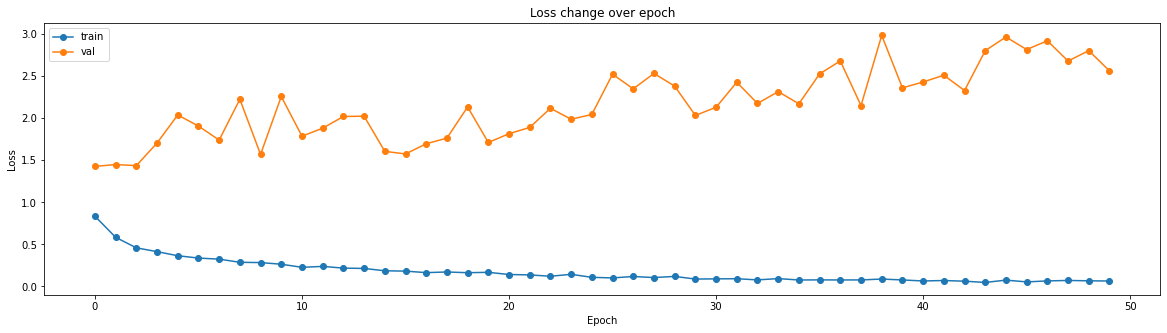

In [108]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()
plt.savefig('outputs\loss_mobilenet_v3_large.jpg')

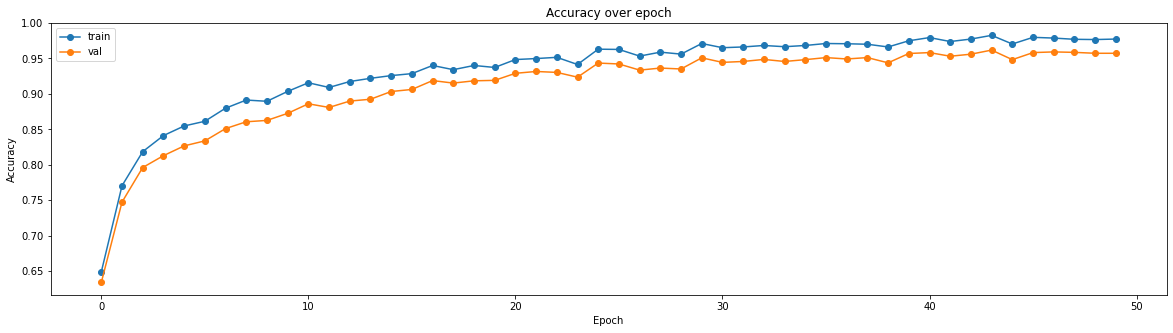

In [109]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()
plt.savefig('outputs\\Accuracy_mobilenet_v3_large.jpg')